In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Here, Qnom is set as the nominal capacity of the battery in ampere-hours (Ah). folder_path is the path to the folder containing the CSV files

In [42]:
Qnom = 3  # Nominal Capacity [Ah]
folder_path = r"C:\Users\Harpreet Singh\Desktop\LG 18650HG2 Li-ion Battery Data and Example Deep Neural Network xEV SOC Estimator Script\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\25degC"


In this segment, we iterate over the files in the folder_path directory using a for loop. For each file, we construct the full file path using os.path.join(). Then, we use pd.read_csv() to read the CSV file into a DataFrame. We specify skiprows=30 to skip the first 30 rows and usecols=[8, 9, 10, 11] to select the columns I, J, K, and L. The DataFrame is then converted to a NumPy array using .values.astype(float), and the resulting array is appended to the Data_p25 list.

In [43]:
p25 = os.listdir(folder_path)
Data_p25 = []

for file_name in p25:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, skiprows=30, usecols=[8, 9, 10, 11])
    data = df.values.astype(float)
    Data_p25.append(data)

Here, we extract the columns of interest from the Data_p25 list and concatenate them using np.concatenate(). The resulting arrays are assigned to variables Voltage_p25, Current_p25, T_p25, and Ah_p25.

Forexample: The expression `data[:, 0]` for data in Data_p25 is a list comprehension that extracts the values from the 0th column of each array in the Data_p25 list.

In [44]:
Voltage_p25 = np.concatenate([data[:, 0] for data in Data_p25])
Current_p25 = np.concatenate([data[:, 1] for data in Data_p25])
T_p25 = np.concatenate([data[:, 2] for data in Data_p25])
Ah_p25 = np.concatenate([data[:, 3] for data in Data_p25])

## Calculating the state of charge (SOC):
In this line, the state of charge (SOC) is calculated using the formula SOC_p25 = 1 + Ah_p25 / Qnom. It computes the SOC values based on the Ah_p25 values and the nominal capacity (Qnom).

In [45]:
SOC_p25 = 1 + Ah_p25 / Qnom
McMaster_p25 = np.column_stack((Voltage_p25, Current_p25, T_p25, SOC_p25))


## Plotting 

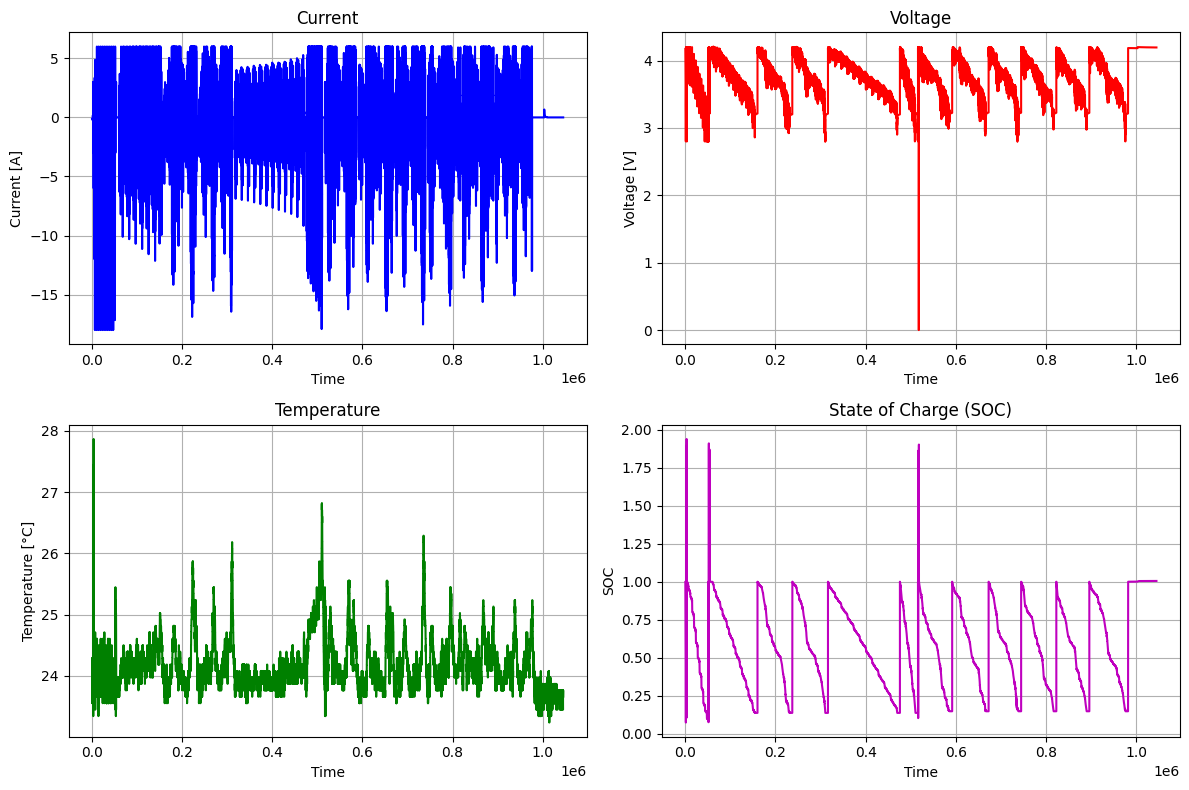

In [46]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(Current_p25, 'b')
plt.title('Current')
plt.xlabel('Time')
plt.ylabel('Current [A]')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Voltage_p25, 'r')
plt.title('Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [V]')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(T_p25, 'g')
plt.title('Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(SOC_p25, 'm')
plt.title('State of Charge (SOC)')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.grid(True)

plt.tight_layout()
plt.show()

#

In [47]:
# Save McMaster_p25 to CSV
np.savetxt('McMaster_p25.csv', McMaster_p25, delimiter=',')

In [19]:
from sklearn.neighbors import LocalOutlierFactor
def plot_outliers(df, feature, threshold=3):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold

    print(f"Rejection {(~good).sum()} points")
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good
    
def plot_lof_outliers(df, feature):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001, p=1)
    good = lof.fit_predict(df) > 0.5 # change this value to set the threshold for outliers
    print(f"Rejection {(~good).sum()} points")
    
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good

In [2]:
import pandas as pd 
# Define column labels
column_labels = ['Voltage', 'Current', 'Temperature', 'SOC']

# Load McMaster_p25.csv with column labels
df = pd.read_csv('McMaster_p25.csv', header=None, names=column_labels)

Rejection 1804 points


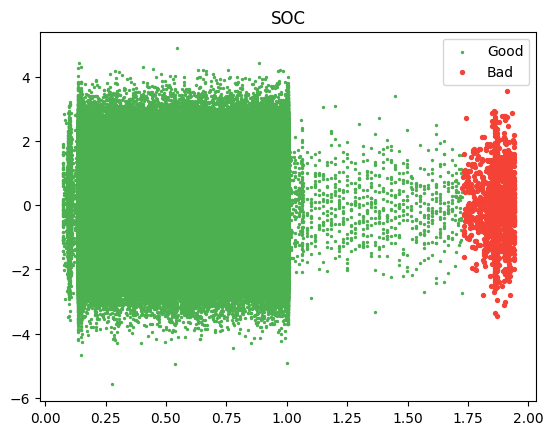

In [22]:
good = plot_outliers(df['SOC'], 'SOC', threshold=4)

In [23]:
df = df[good]
print('Now train_df has %d rows.' % (df.shape[0]))

Now train_df has 1043637 rows.


Rejection 27 points


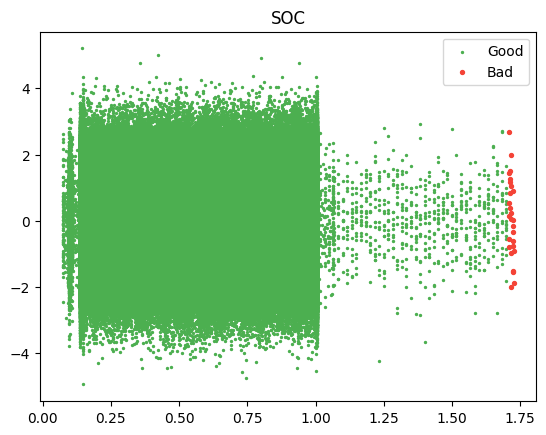

In [24]:
good = plot_outliers(df['SOC'], 'SOC', threshold=4)

In [25]:
df = df[good]
print('Now train_df has %d rows.' % (df.shape[0]))

Now train_df has 1043610 rows.


In [11]:
FEATURES = ['Voltage', 'Current', 'Temperature']

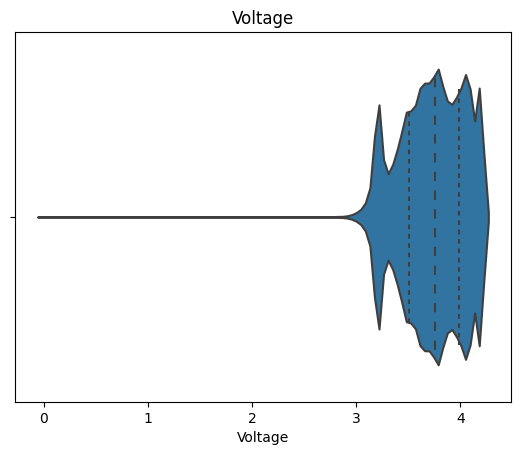

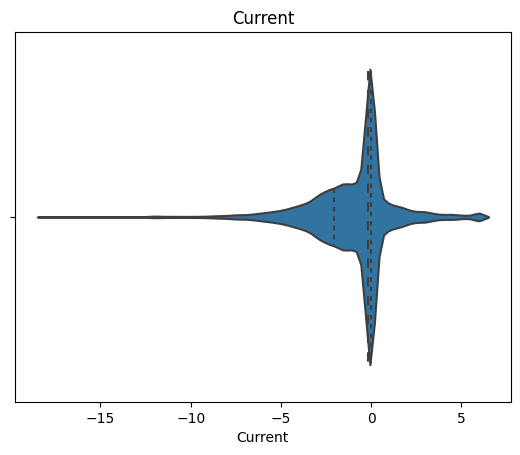

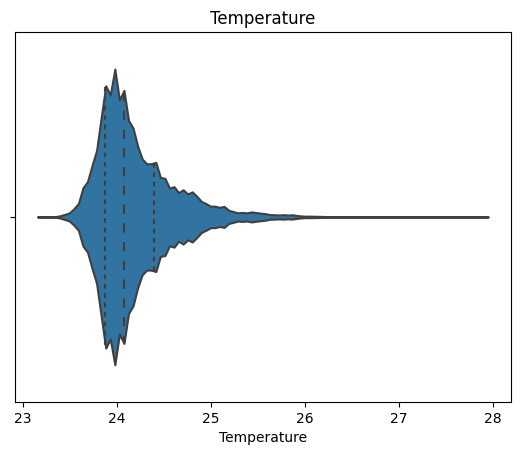

In [14]:
import seaborn as sns
for feature in FEATURES:
    sns.violinplot(x=df[feature], inner='quartile', bw=0.1)
    plt.title(feature)
    plt.show();

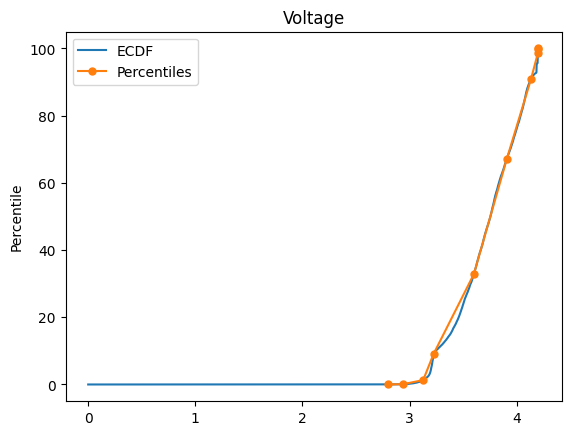

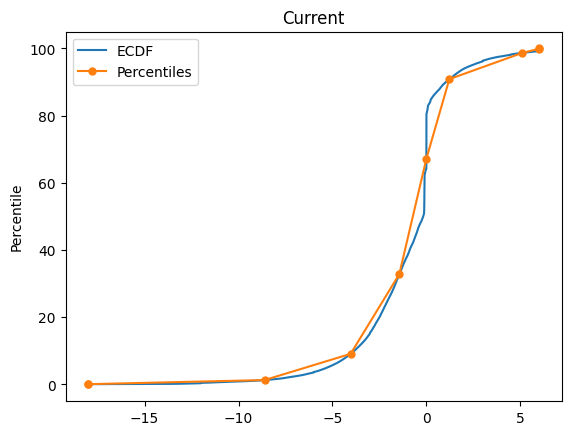

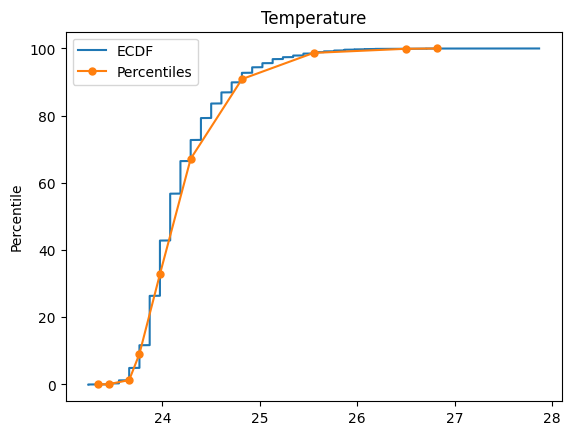

In [16]:
import scipy.stats as st
def plot_cdf(df, feature):
    ps = 100 * st.norm.cdf(np.linspace(-4, 4, 10)) # The last number in this tuple is the number of percentiles
    x_p = np.percentile(df, ps)

    xs = np.sort(df)
    ys = np.linspace(0, 1, len(df))

    plt.plot(xs, ys * 100, label="ECDF")
    plt.plot(x_p, ps, label="Percentiles", marker=".", ms=10)
    plt.legend()
    plt.ylabel("Percentile")
    plt.title(feature)
    plt.show();

for feature in FEATURES:
    plot_cdf(df[feature], feature)

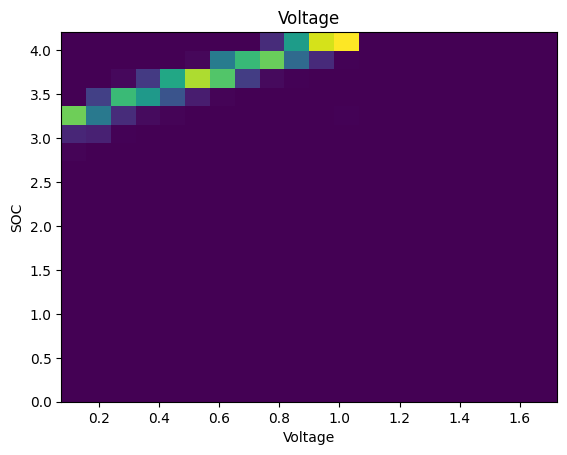

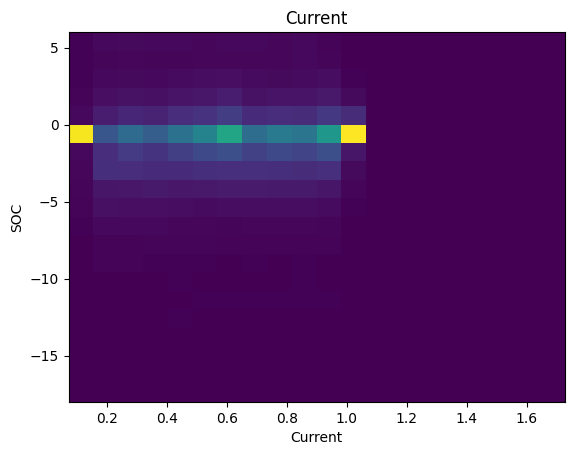

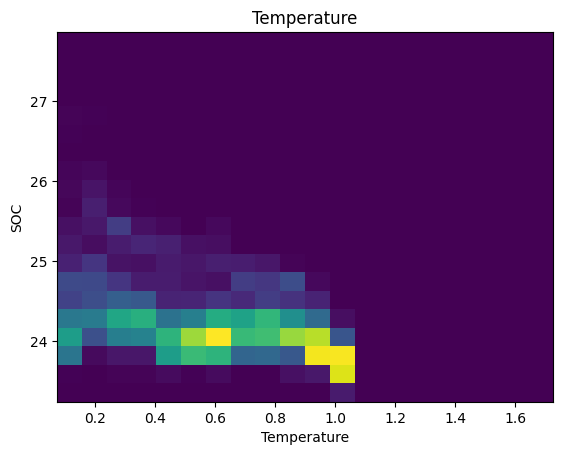

In [17]:
for feature in FEATURES:
    #sns.kdeplot(x=train_df['target'], y=train_df[feature], bins=20, cmap='magma', shade=True) 
    plt.hist2d(x=df['SOC'], y=df[feature], bins=20)
    plt.xlabel(feature)
    plt.ylabel('SOC')
    plt.title(feature)
    plt.show()

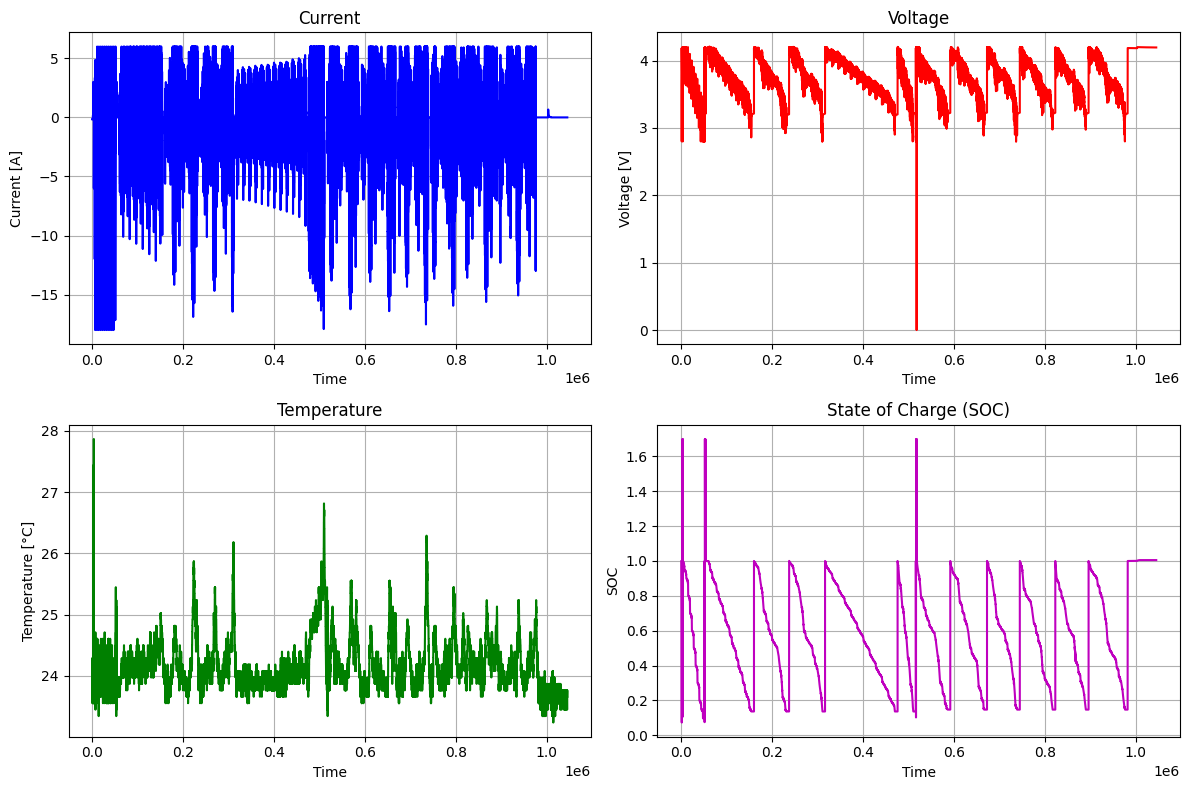

In [27]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df['Current'], 'b')
plt.title('Current')
plt.xlabel('Time')
plt.ylabel('Current [A]')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(df['Voltage'], 'r')
plt.title('Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [V]')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(df['Temperature'], 'g')
plt.title('Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(df['SOC'], 'm')
plt.title('State of Charge (SOC)')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.grid(True)
df.to_csv('McMaster_cleaned.csv', index=False)

plt.tight_layout()
plt.show()